In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [186]:
# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (7, 2.5)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [29]:
df = pd.read_csv("../data/repoissuedata.csv.gz", compression='gzip')
df

,Unnamed: 0,message,filepath,line,column,kind,snippet,end_column,workflow_content,repository,...,commiter_name,commiter_email,date,workflow,change_type,lines_count,commit_year,commit_mon_year,next_commit,status
0,1205281,"""steps"" section is missing in job ""Ubuntu""",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,4,3,syntax-check,Ubuntu:\n ^~~~~~~,9,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,Danny McCormick,damccorm@microsoft.com,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed
1,1205282,"unexpected key ""actions"" for ""job"" section. ex...",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,7,5,syntax-check,actions:\n ^~~~~~~~,12,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,Danny McCormick,damccorm@microsoft.com,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed
2,1205283,"""steps"" section is missing in job ""Windows""",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,30,3,syntax-check,Windows:\n ^~~~~~~~,10,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,Danny McCormick,damccorm@microsoft.com,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed
3,1205284,"unexpected key ""actions"" for ""job"" section. ex...",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,33,5,syntax-check,actions:\n ^~~~~~~~,12,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,Danny McCormick,damccorm@microsoft.com,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed
4,18575,"workflow command ""set-env"" was deprecated. use...",039caf0a23b2880cc6df745d11bda55cd77af51cac105a...,41,12,deprecated-commands,run: |\n ^,12,039caf0a23b2880cc6df745d11bda55cd77af51cac105a...,actions---toolkit,...,GitHub,noreply@github.com,2020-04-23 20:52:53,.github/workflows/artifact-tests.yml,A,78,2020,2020-04,628f82f22156d17814bfe7876fe3581456e9a9f3,open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304194,887498,"workflow command ""set-output"" was deprecated. ...",ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,95,14,deprecated-commands,run: |\n ^,14,ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,intelligent-machine-learning---dlrover,...,GitHub,noreply@github.com,2023-10-11 11:28:42,.github/workflows/main.yml,M,117,2023,2023-10,NaN,closed
1304195,887499,"workflow command ""set-output"" was deprecated. ...",ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,95,14,deprecated-commands,run: |\n ^,14,ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,intelligent-machine-learning---dlrover,...,GitHub,noreply@github.com,2023-10-11 11:28:42,.github/workflows/main.yml,M,117,2023,2023-10,NaN,closed
1304196,887497,"workflow command ""set-output"" was deprecated. ...",ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,95,14,deprecated-commands,run: |\n ^,14,ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,intelligent-machine-learning---dlrover,...,GitHub,noreply@github.com,2023-10-11 11:28:42,.github/workflows/main.yml,M,117,2023,2023-10,NaN,closed
1304197,1178738,"property ""workspace"" is not defined in object ...",e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...,20,40,expression,run: |,40,e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...,galkahana---pdf-writer,...,GitHub,noreply@github.com,2023-10-11 12:21:27,.github/workflows/ci-xmake-linux.yml,A,42,2023,2023-10,NaN,closed


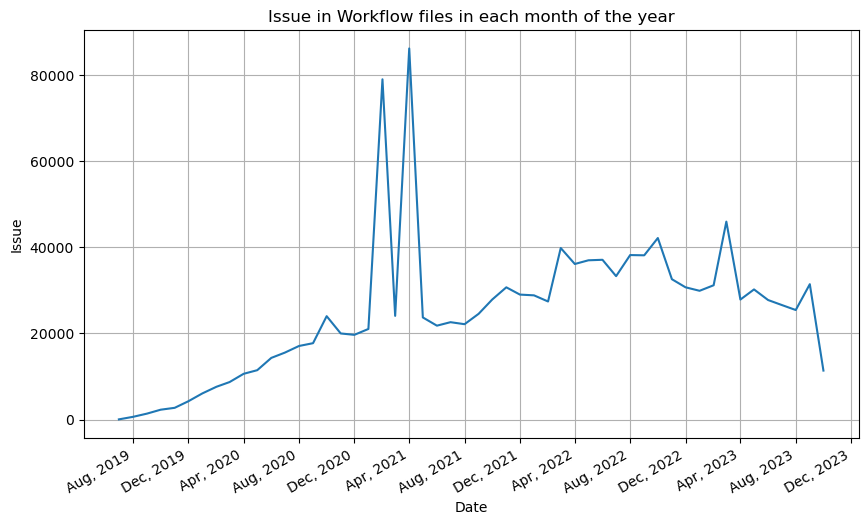

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = (
    df
    .groupby(['commit_mon_year'], sort=True)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

# converting the date to numeric
dates = mdates.date2num(no_of_issue.index)

ax.plot(dates, no_of_issue['no_of_issue'])
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

In [61]:
df['kind'].value_counts()

deprecated-commands    543532
expression             292206
syntax-check           217987
runner-label           134139
yaml-syntax             37298
matrix                  23520
events                  18617
action                  15106
pyflakes                 8648
glob                     7119
job-needs                3252
id                       1347
shell-name                632
env-var                   401
permissions               235
workflow-call             160
Name: kind, dtype: int64

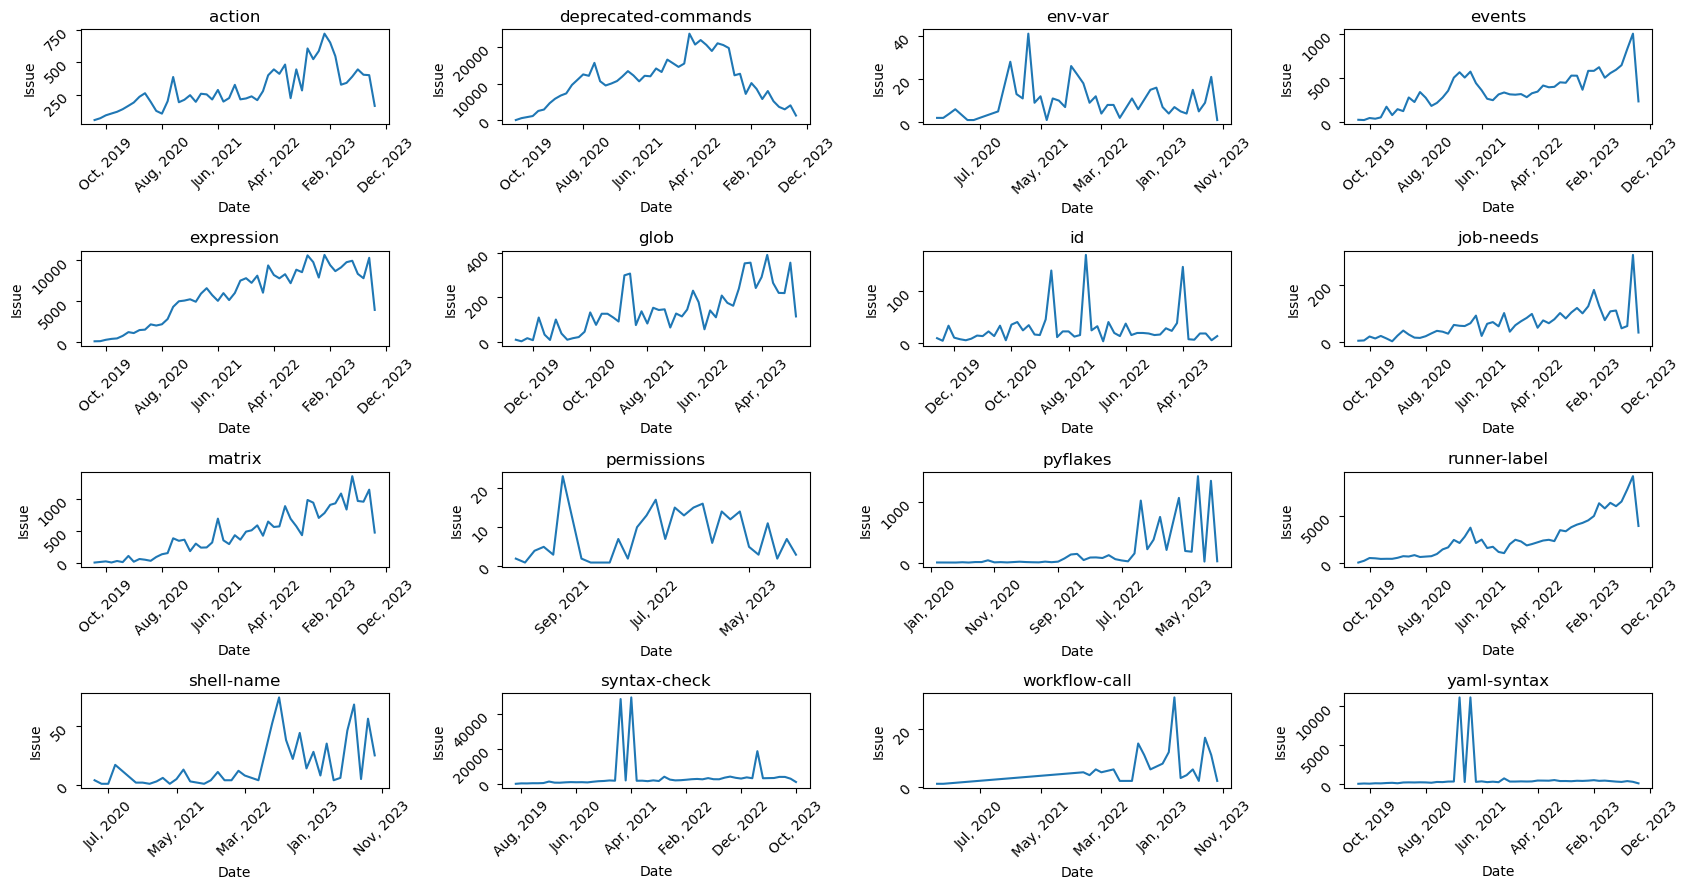

In [196]:
no_issue_kind = (
    df
    .groupby(['kind','commit_mon_year'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

kinds = no_issue_kind['kind'].unique()

def plotnew(ax, kind):
    data = no_issue_kind[no_issue_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')
   
    ax.set_title(kind)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=4, ncols=4)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plotnew(ax, kinds[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

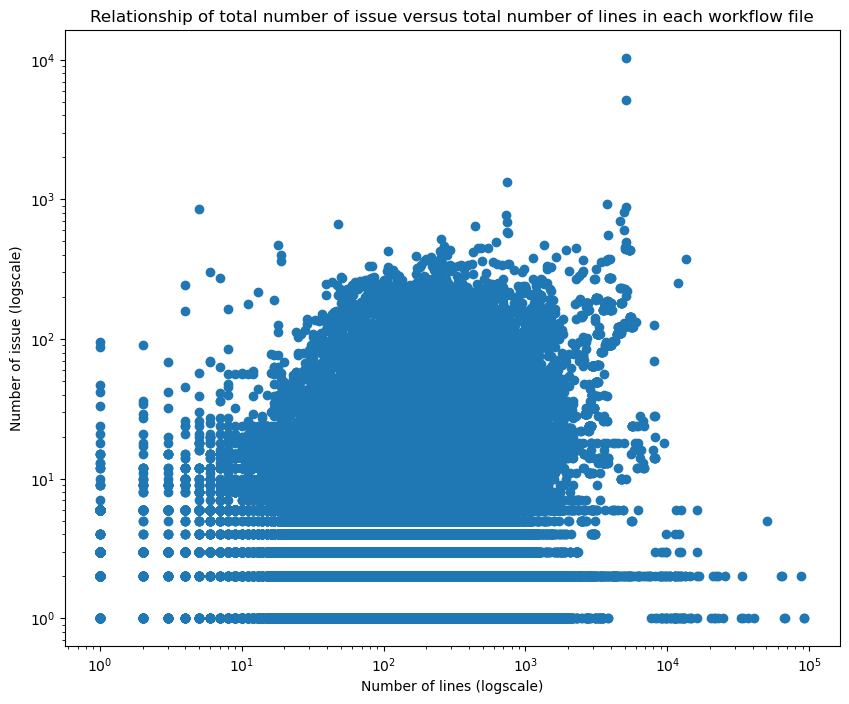

In [185]:
wf_issue_count = (
    df
    .groupby(['workflow','lines_count'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.scatter(x=wf_issue_count['lines_count'], y=wf_issue_count['no_of_issue'])
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Relationship of total number of issue versus total number of lines in each workflow file')
plt.xlabel('Number of lines (logscale)')
plt.ylabel('Number of issue (logscale)')

plt.yscale("log")
plt.xscale("log")


plt.show()

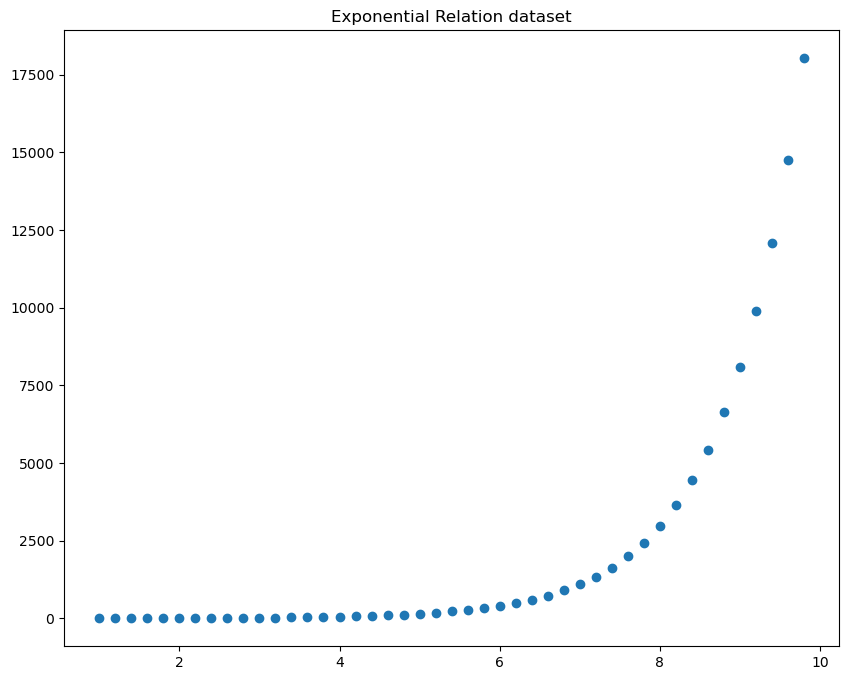

In [193]:
# Scatterplot of non-random vzriables
x=np.arange(1,10,0.2)
y= np.exp(x)
plt.scatter(x,y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Exponential Relation dataset')
plt.show()

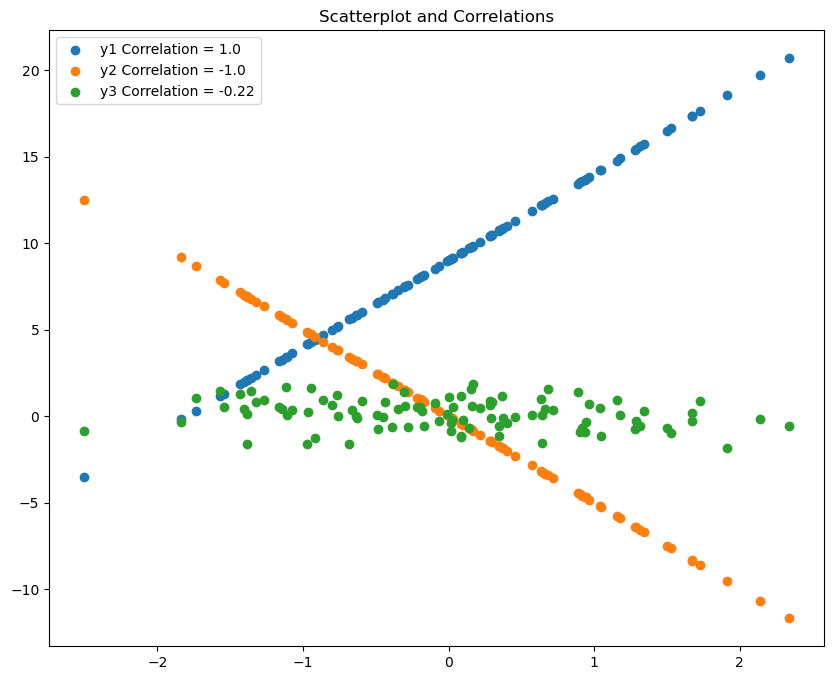

In [84]:
# Scatterplot and Correlations
# Data
x=np.random.randn(100)
y1= x*5 +9 
y2= -5*x
y3=np.random.randn(100)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y1, label=f'y1 Correlation = {np.round(np.corrcoef(x,y1)[0,1], 2)}')
plt.scatter(x, y2, label=f'y2 Correlation = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'y3 Correlation = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

# Plot
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

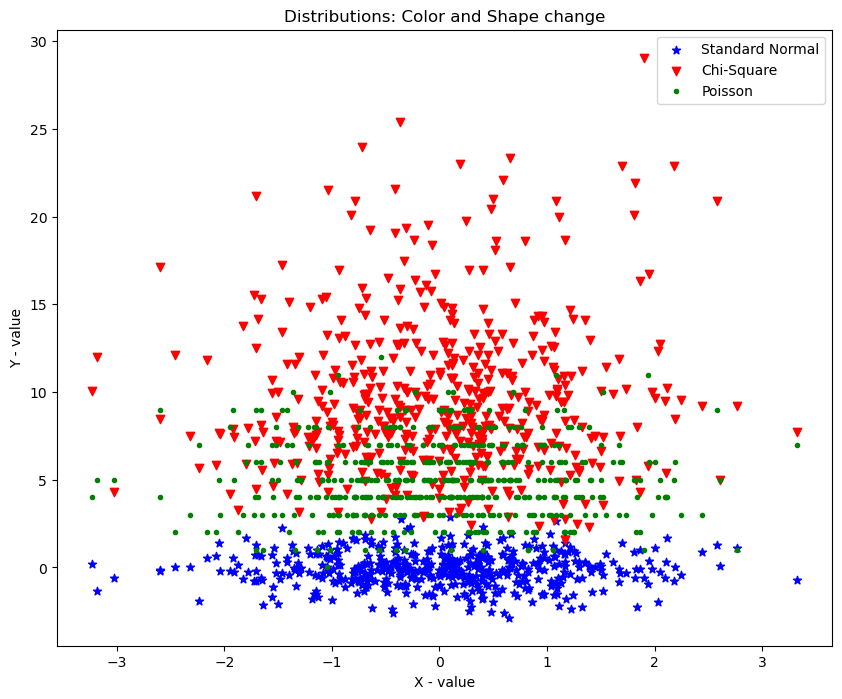

In [85]:
# Scatterplot of different distributions. Color and Shape of Points.
x = np.random.randn(500)
y1 = np.random.randn(500)
y2 = np.random.chisquare(10, 500)
y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='Standard Normal')
plt.scatter(x,y2,color= 'red', marker='v', label='Chi-Square')
plt.scatter(x,y3,color= 'green', marker='.', label='Poisson')


# Decorate
plt.title('Distributions: Color and Shape change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.legend(loc='best')
plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_51258/2557530208.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['A'], hist=True, kde=True,


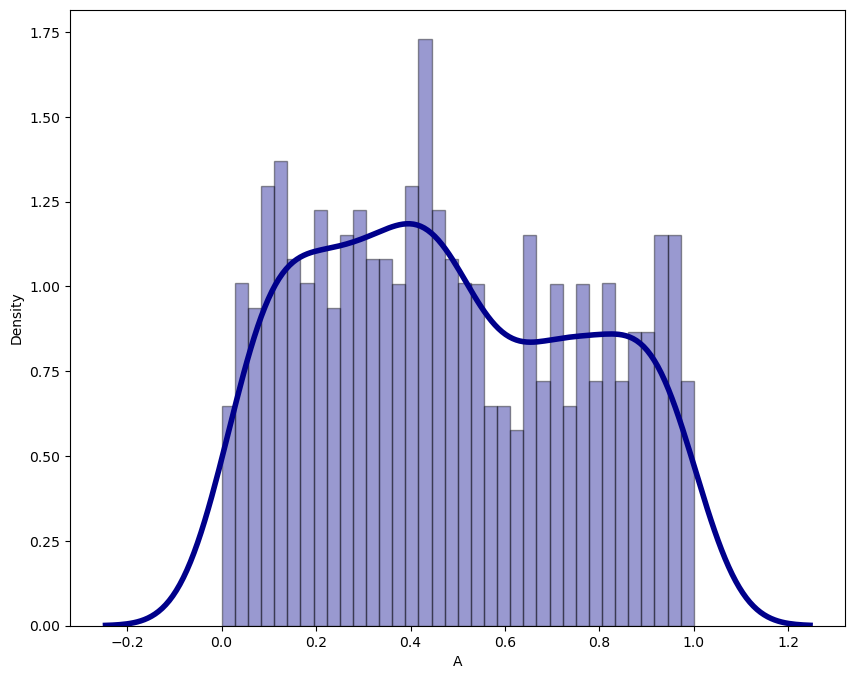

In [87]:
import seaborn as sns

df1 = pd.DataFrame(np.random.rand(500, 1), columns=['A'])
sns.distplot(df1['A'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});